## Training Set

In [1]:
import os
import numpy as np

In [2]:
# loiding the training data
cats_path = os.listdir("../input/dogs-cats-images/dataset/training_set/cats/")
dogs_path = os.listdir("../input/dogs-cats-images/dataset/training_set/dogs/")
cats_full_path = ["../input/dogs-cats-images/dataset/training_set/cats/" + fname for fname in cats_path]
dogs_full_path = ["../input/dogs-cats-images/dataset/training_set/dogs/" + fname for fname in dogs_path]
X = cats_full_path + dogs_full_path
cats_labels = [0]*len(cats_full_path)
dogs_labels = [1]*len(dogs_full_path)
y = cats_labels + dogs_labels

In [3]:
from IPython.display import display, Image

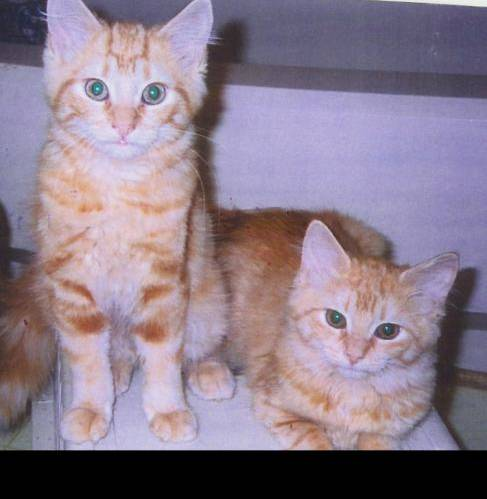

In [4]:
# showing an image example
Image(cats_full_path[7])

In [5]:
len(X), len(y)

(8000, 8000)

## Spliting the Data 

In [6]:
from sklearn.model_selection import train_test_split

# creating a validation set from train set
X_train, X_val, y_train, y_val = train_test_split(X,
                                                  y, 
                                                  test_size=0.2,
                                                  random_state=42, shuffle=True, stratify=y)

## Convert images to tensors


In [7]:
import tensorflow as tf

In [8]:
# Check GPU 
print("GPU available" if tf.config.list_physical_devices("GPU") else "not available");

GPU available


2021-11-09 22:28:26.014434: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-09 22:28:26.123993: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-09 22:28:26.124719: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [9]:
# image size
IMG_SIZE = 200

def process_image(image_path):
    """
    Convert an image file path and turns it into a Tensor.
    """
    # Read an image from path
    image = tf.io.read_file(image_path)
    # Decode the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
    image = tf.image.decode_jpeg(image, channels=3)
    # Convert the colour channel values from 0-225 to 0-1 values
    image = tf.image.convert_image_dtype(image, tf.float32)
    # Resize the image to our desired size IMG_SIZE
    image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
    return image

In [10]:
# function to return a tuple (image, label)
def get_image_label(image_path, label):
    """
    Takes an image file path name and the associated label,
    processes the image and returns a tuple of (image, label).
    """
    image = process_image(image_path)
    return image, label

In [11]:
# batch size of 32 is a good default
BATCH_SIZE = 32

# function to turn data into batches
def create_data_batches(x, y, batch_size=BATCH_SIZE):
    """
    Creates batches of data out of image (x) and label (y) pairs.
    """
    print("Creating data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                               tf.constant(y))) # labels  
    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)
    # Turn the data into batches
    data_batch = data.batch(BATCH_SIZE)
    return data_batch

In [12]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val)

Creating data batches...
Creating data batches...


2021-11-09 22:28:26.372652: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-09 22:28:26.373929: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-09 22:28:26.374648: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-09 22:28:26.375320: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [13]:
# function which builds our model
def create_model():
    # building the model
    model = tf.keras.models.Sequential([
    # building our CNN 
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 'Cat' and 1 for 'Dog' 
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        loss=tf.keras.losses.binary_crossentropy,
        optimizer=tf.keras.optimizers.Adam(), 
        metrics='accuracy'
    )
    
    return model

In [14]:
# Creating our model 
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 64)        1

In [15]:
# Create early stopping (callback function) (once our model stops improving, stop training)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3) # stops after 3 rounds of no improvements

In [16]:
# number of epochs
NUM_EPOCHS = 20

In [17]:
# function to train and return a trained model
def train_model():
    """
    Trains a given model and returns the trained version.
    """
    # Create a model
    model = create_model()

    history = model.fit(
        train_data,
        epochs=NUM_EPOCHS,
        validation_data=val_data,
        callbacks= [early_stopping])
  
    return model, history

In [18]:
# Fit the model to the data
model, history = train_model()

2021-11-09 22:28:30.193042: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2021-11-09 22:28:31.854189: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


200/200 [==============================] - 36s 143ms/step - loss: 0.6751 - accuracy: 0.5516 - val_loss: 0.6487 - val_accuracy: 0.6156
Epoch 2/20
200/200 [==============================] - 13s 66ms/step - loss: 0.5980 - accuracy: 0.6756 - val_loss: 0.6094 - val_accuracy: 0.6781
Epoch 3/20
200/200 [==============================] - 13s 65ms/step - loss: 0.5335 - accuracy: 0.7353 - val_loss: 0.5894 - val_accuracy: 0.6988
Epoch 4/20
200/200 [==============================] - 13s 66ms/step - loss: 0.4836 - accuracy: 0.7686 - val_loss: 0.5220 - val_accuracy: 0.7394
Epoch 5/20
200/200 [==============================] - 13s 65ms/step - loss: 0.4463 - accuracy: 0.7886 - val_loss: 0.4890 - val_accuracy: 0.7650
Epoch 6/20
200/200 [==============================] - 13s 64ms/step - loss: 0.3892 - accuracy: 0.8220 - val_loss: 0.4601 - val_accuracy: 0.8025
Epoch 7/20
200/200 [==============================] - 13s 64ms/step - loss: 0.3369 - accuracy: 0.8541 - val_loss: 0.4545 - val_accuracy: 0.8019
Ep

In [19]:
# model accuracy
test_data = create_data_batches(X_val, y_val)
model.evaluate(test_data)

Creating data batches...
50/50 [==============================] - 2s 46ms/step - loss: 0.6401 - accuracy: 0.7788


[0.6401348114013672, 0.7787500023841858]

## Evaluating model accuracy 

In [20]:
import matplotlib.pyplot as plt

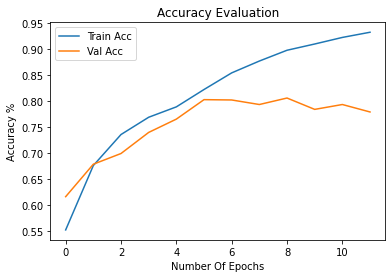

In [21]:
# Accuracy Evaluation
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Number Of Epochs')
plt.ylabel('Accuracy %')
plt.title('Accuracy Evaluation')
plt.legend()
plt.show()

## Evaluating model loss 

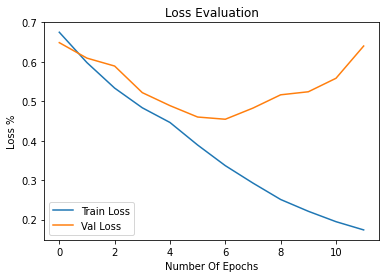

In [22]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Evaluation')
plt.ylabel('Loss %')
plt.xlabel('Number Of Epochs')
plt.legend(['Train Loss', 'Val Loss'], loc='lower left')
plt.show()

## Visualizing the predections

In [23]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data, verbose=1) # verbose shows us how long there is to go
# Check the shape of predictions
predictions.shape

50/50 [==============================] - 2s 45ms/step


(1600, 1)

In [24]:
# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(pred_probs):
    """
    Turns an array of prediction probabilities into a label.
    """
    return 0 if pred_probs<.5 else 1

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[0])
pred_label

1

In [25]:
# Create a function to unbatch a batched dataset
def unbatchify(data):
    """
    Takes a batched dataset of (image, label) Tensors and returns separate arrays
    of images and labels.
    """
    images = []
    labels = []
    # Loop through unbatched data
    for image, label in data.unbatch().as_numpy_iterator():
        images.append(image)
        labels.append(label)
    return images, labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.4918352 , 0.5310509 , 0.63693327],
         [0.5171428 , 0.55635846, 0.6622408 ],
         [0.53386337, 0.5797641 , 0.6823039 ],
         ...,
         [0.18110856, 0.07130463, 0.05953993],
         [0.29191512, 0.18805218, 0.18222846],
         [0.2645458 , 0.18611442, 0.19003598]],
 
        [[0.46567652, 0.5048922 , 0.6107745 ],
         [0.486951  , 0.52806866, 0.633     ],
         [0.5095374 , 0.55840385, 0.6603646 ],
         ...,
         [0.2073068 , 0.10958924, 0.09390297],
         [0.2723903 , 0.17732158, 0.1675763 ],
         [0.23431988, 0.16373163, 0.16373163]],
 
        [[0.48419487, 0.52450985, 0.6298425 ],
         [0.48873347, 0.53579235, 0.6377531 ],
         [0.50784624, 0.5610754 , 0.66303617],
         ...,
         [0.26418915, 0.1751724 , 0.16556463],
         [0.19064312, 0.10708586, 0.09553693],
         [0.1903793 , 0.12763421, 0.12763421]],
 
        ...,
 
        [[0.9135975 , 0.8037936 , 0.7881073 ],
         [0.8363291 , 0.74518204, 0.72355

In [26]:
def plot_pred(pred_probs, labels, images):
    """
    View the prediction, ground truth label and image for a random sample n.
    """
    n = np.random.randint(0,len(images))    
    pred_prob, true_label, image = pred_probs[n], labels[n], images[n]
    # Get the pred label
    pred_label = get_pred_label(pred_prob)
  
    # Plot image & remove ticks
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])

    # Change the color of the title depending on if the prediction is right or wrong
    if pred_label == true_label:
        color = "green"
    else:
        color = "red"

    plt.title("pred=> {} with prob= {:2.0f}% : label= ({})".format(pred_label,
                                      pred_prob[0]*100,
                                      true_label),
                                      color=color)

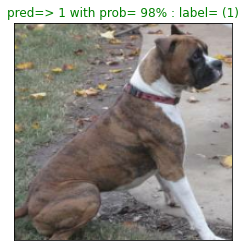

In [27]:
# View an example prediction, original image and truth label
plot_pred(pred_probs=predictions,
          labels=val_labels,
          images=val_images)

# Evaluating The Test Data

In [28]:
# loiding the test data
test_cats_path = os.listdir("../input/dogs-cats-images/dataset/test_set/cats/")
test_dogs_path = os.listdir("../input/dogs-cats-images/dataset/test_set/dogs/")
test_cats_full_path = ["../input/dogs-cats-images/dataset/test_set/cats/" + fname for fname in cats_path]
test_dogs_full_path = ["../input/dogs-cats-images/dataset/test_set/dogs/" + fname for fname in dogs_path]
# creating test feature
X_test = cats_full_path + dogs_full_path
test_cats_labels = [0]*len(cats_full_path)
test_dogs_labels = [1]*len(dogs_full_path)
# creating test label
y_test = test_cats_labels + test_dogs_labels

In [29]:
# Create test
test_data = create_data_batches(X_test, y_test)
model.evaluate(test_data)

Creating data batches...
250/250 [==============================] - 12s 47ms/step - loss: 0.2923 - accuracy: 0.8901


[0.2922584116458893, 0.8901249766349792]